In [1]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [3]:
# !jt -t monokai
# !jt -r

In [4]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy

from covid_data_helper import *
from coronita_model_helper import *
%load_ext autoreload
%autoreload 2

In [5]:
# ## DATA INGESTION ##

# df_st_testing = get_covid19_tracking_data()

# df_census = get_census_pop()

# df_counties = get_complete_county_data()

# counties_geo = get_counties_geo()

# df_jhu_counties = get_jhu_counties()

# df_st_testing_fmt = df_st_testing.copy()
# df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

# df_interventions = get_state_policy_events()

# df_goog_mob_us = get_goog_mvmt_us()
# df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
# df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

# #######################

In [6]:
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)
    

./output/allstate_model_dicts_20210205.pkl


In [7]:
# l_states_to_fore = df_census.state.unique()
l_states_to_fore = ['NY']

In [8]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

#######################

### RUN MODEL ###
df_fore_allstates = pd.DataFrame()

try:
    list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print('last forecast: ', latest_file)
    df_prevfore_allstates = pd.read_pickle(latest_file)
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()

last forecast:  ./output/df_fore_allstates_20210205.pkl


In [9]:
# allstate_model_dicts['ND']['df_all_cohorts'
#                           ].loc[:,:'2020-12-20'].sum(axis=1).unstack('metric').iloc[-270:-120].plot()
# # allstate_model_dicts['ND']['df_agg']


In [10]:
# state= 'ND'

# model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
#                                    covid_params, days_to_forecast,
#                                    df_mvmt=df_goog_mob_state
#                                  , df_interventions=df_interventions
#                                   )

# this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
# this_reg_df_wavg = pd.DataFrame(
#     model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

# # df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
# # df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

# try:
#     first_guess = df_prevfore_allstates[state].first_valid_index()[0]
# except:
#     first_guess = pd.Timestamp('2020-02-17')

# model_dict = model_find_start(first_guess, model_dict)
# df_agg = model_dict['df_agg']
# df_all_cohorts = model_dict['df_all_cohorts']

# print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
# print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
# print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
# print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

# model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

In [11]:
def ode_model(z, t, beta, sigma, gamma, mu):
    """
    Reference https://www.idmod.org/docs/hiv/model-seir.html
    """
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def ode_solver(t, initial_conditions, covid_params):
    initE, initI, initR, initN, initD = initial_conditions
    beta, sigma, gamma, mu = params['beta'].value, params['sigma'].value, params['gamma'].value, params['mu'].value
    initS = initN - (initE + initI + initR + initD)
    res = odeint(ode_model, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return res



In [12]:
allstate_model_dicts['NY']['df_rts']['weighted_average'].dropna()

2020-02-21    3.611777
2020-02-22    3.496134
2020-02-23    3.347290
2020-02-24    3.188077
2020-02-25    3.015913
                ...   
2021-01-24    0.845710
2021-01-25    0.820476
2021-01-26    0.794907
2021-01-27    0.771144
2021-01-28    0.750836
Freq: D, Name: weighted_average, Length: 343, dtype: float64

In [13]:
model_dict = allstate_model_dicts['NY'].copy()


## Basic Non-Cohort Version

N           9.635304e+07
E           1.025800e+03
E_new       3.183764e+02
I_Mild      1.514794e+03
I_Sev       9.363140e+01
I_Fatal     3.121047e+01
H_Sev       2.320206e+02
H_Fatal     1.687385e+02
H_Admits    1.844890e+01
R           3.607733e+06
D           3.626039e+04
Name: 2021-05-20 23:00:00, dtype: float64


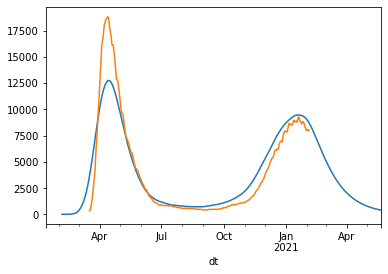

In [14]:
def noncohort_ode_model_basic(z, t_, r_ts, covid_params):
    S, E, E_new, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    N = S + E + I_Mild + I_Sev + I_Fatal + H_Sev + H_Fatal + R + D
    I = I_Mild + I_Sev + I_Fatal
    H = H_Sev + H_Fatal
    
    
    if int(t_) < r_ts.shape[0]:
        try:
            r_t = r_ts.iloc[int(t_)]
        except:
            print(int(t_))
    else:
        r_t = r_ts.iloc[-1]

    ## FLOWS ##
    
    _sigma = 1/covid_params['d_incub']
    _gamma = 1/covid_params['d_infect']
    _beta = r_t * _gamma
    _nu = 1/covid_params['d_to_hosp']
    _rho = 1/covid_params['d_in_hosp']
    _mu = 1/covid_params['d_til_death']
    
    p_fatal = covid_params['mort_rt']
    p_recov_sev = covid_params['hosp_rt'] - covid_params['mort_rt']
    p_recov_mild = 1 - covid_params['hosp_rt']

    dSdt = -min(_beta*I, S) #-_beta*S*I/N
    dEdt = min(_beta*I, S) - _sigma*E #_beta*S*I/N - _sigma*E
    E_new = min(_beta*I, S) - E_new
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dSdt, dEdt, E_new, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

start_dt = '2020-02-05 11:00'
end_dt = '2021-05-21'
days = (pd.Timestamp(end_dt) - pd.Timestamp(start_dt)).total_seconds() / (24 * 60 * 60)
hrs_per_point = 6
granularity = hrs_per_point/24.
initN = 1e8
initE, E_new = 1e2, 1e2
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initN, initE, E_new,
                      initI_Mild, initI_Sev, initI_Fatal, 
                      initH_Sev, initH_Fatal, initH_Admits, 
                      initR, initD]


r_ts = model_dict['df_rts']['weighted_average'].dropna().reindex(
    pd.date_range(start_dt,end_dt, freq=f'1D').normalize()).interpolate().fillna(method='ffill').fillna(method='bfill')
r_ts.index = (r_ts.index - pd.Timestamp(start_dt)).days

tspan = np.arange(0, days, granularity)
# ode_r_ts = r_ts.interpolate()
# ode_r_ts.index = tspan

# r_ts = model_dict['df_rts']['weighted_average'].dropna().reindex(
#     pd.date_range(start_dt,end_dt, freq=f'{hrs_per_point}H'))
# ode_r_ts = r_ts.interpolate()
# ode_r_ts.index = ode_r_ts.index.to_numpy().astype(int)
# tspan = ode_r_ts.index

sol = odeint(noncohort_ode_model_basic, initial_conditions, tspan, args=(r_ts,covid_params,))

df_sol = pd.DataFrame(sol, 
                      columns=['N', 'E', 'E_new', 
                               'I_Mild', 'I_Sev', 'I_Fatal', 
                               'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=pd.date_range(start_dt, end_dt, freq=f'{hrs_per_point}H'))
# df_sol.plot(); plt.show()
# df_sol.R.diff().plot(); plt.show()
df_sol[['H_Sev','H_Fatal']].sum(axis=1).plot()
model_dict['df_hist']['hosp_concur'].plot()

print(df_sol.iloc[-1])



## Main Non-Cohort Version with Minimization

In [15]:
from tqdm.notebook import tqdm
from time import sleep
for i in tqdm(range(100)):
    sleep(.01)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
def noncohort_ode_model(z, t_, r_ts, params):
    S, E, E_new, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    N = S + E + I_Mild + I_Sev + I_Fatal + H_Sev + H_Fatal + R + D
    I = I_Mild + I_Sev + I_Fatal
    H = H_Sev + H_Fatal
    
    try:
        r_t = r_ts.loc[int(t_)]
    except:
        print(int(t_))
    
    d_til_death_t = (params['d_til_death'].value - params['d_til_death_curr'].value) \
        / (1 + np.exp(params['mort_logistic_steepness'] * (t_ - 182) ) ) \
        + params['d_til_death_curr'].value

    ## FLOWS ##
    
    _sigma = 1 / params['d_incub'].value
    _gamma = 1 / params['d_infect'].value
    _beta = r_t * _gamma
    _nu = 1 / params['d_to_hosp'].value
    _rho = 1 / params['d_in_hosp'].value
    _mu = 1 / d_til_death_t
#     _mu = 1 / params['d_til_death'].value
    
    p_fatal = (params['mort_rt'].value - params['mort_rt_curr'].value) \
        / (1 + np.exp(params['mort_logistic_steepness'] * (t_ - 182) ) ) \
        + params['mort_rt_curr'].value
    if p_fatal <= 0:
        print(t_, p_fatal)
    p_recov_sev = params['hosp_rt'].value - params['mort_rt'].value
    p_recov_mild = 1 - p_fatal - p_recov_sev

    dSdt = -min(_beta*I, S)
    dEdt = min(_beta*I, S) - _sigma*E
    E_new = min(_beta*I, S) - E_new
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dSdt, dEdt, E_new, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

def run_model(params, initial_conditions, tspan, r_ts):
    start_dt_fmt = pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)
#     print(start_dt_fmt)
    
    r_ts_nodt = r_ts.copy()
    r_ts_nodt.index = (r_ts_nodt.index - start_dt_fmt).days
    
    sol = odeint(noncohort_ode_model, initial_conditions, tspan, args=(r_ts_nodt, params,))
    
    df_sol = sol_array_to_df(sol, params, days, granularity, hrs_per_point)
    return df_sol

def sol_array_to_df(sol, params, days, granularity, hrs_per_point):
    df_sol = pd.DataFrame(sol, 
                      columns=['N', 'E', 'E_new', 
                               'I_Mild', 'I_Sev', 'I_Fatal', 
                               'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=pd.date_range(
                          (pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)), 
                           periods=days/granularity, freq=f'{hrs_per_point}H')
                     )
    agg_dict = {
        'E': 'mean',
        'E_new': 'sum',
        'I_Mild': 'mean',
        'I_Sev': 'mean',
        'I_Fatal': 'mean',
        'H_Sev': 'mean',
        'H_Fatal': 'mean',
        'H_Admits': 'sum', 
        'R': 'max',
        'D': 'max'} 
    df_sol_daily = df_sol.resample('D').agg(agg_dict)
    df_sol_daily['deaths_tot'] = df_sol_daily['D']
    df_sol_daily['deaths_daily'] = df_sol_daily['D'].diff()
    df_sol_daily['hosp_admits'] = df_sol_daily['H_Admits']
    df_sol_daily['hosp_concur'] = df_sol_daily[['H_Sev','H_Fatal']].sum(axis=1)
    return df_sol_daily

def report_model(r_ts, df_sol, model_dict, params, tspan):
    r_ts.plot(); plt.show()

    for series in [ 'hosp_concur', 'hosp_admits', 'deaths_tot', 'deaths_daily']:
        df_sol[series].plot(title=series, label='Model', legend=True)
        try:
            model_dict['df_hist'][series].plot(title=series, label='Reported Data', legend=True)
        except:
            pass
        plt.show()
    
    mort_rt_t = ( (params['mort_rt'].value - params['mort_rt_curr'].value)
                        / (1 + np.exp(params['mort_logistic_steepness'] * (tspan - 182) ) )
                        + params['mort_rt_curr'].value)
    mort_rt_idx = pd.date_range(start = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)), 
                                periods = days/granularity, 
                                freq = f'{hrs_per_point}H')
    mort_rt_t = pd.Series(mort_rt_t, index = mort_rt_idx)
    mort_rt_t.plot(title='mort_rt_t')
    plt.show()
    
    d_til_death_t = ( (params['d_til_death'].value - params['d_til_death_curr'].value)
                        / (1 + np.exp(params['mort_logistic_steepness'] * (tspan - 182) ) )
                        + params['d_til_death_curr'].value)
    d_til_death_idx = pd.date_range(start = (pd.Timestamp('2020-01-01') + pd.Timedelta(days=params['start_dt'].value)), 
                                periods = days/granularity, 
                                freq = f'{hrs_per_point}H')
    d_til_death_t = pd.Series(d_til_death_t, index = d_til_death_idx)
    d_til_death_t.plot(title='d_til_death_t')
    plt.show()

    print(df_sol.iloc[-1])
    return

def param_min_sequence(state_code, allstate_model_dicts):
    model_dict = allstate_model_dicts[state_code].copy()
    print(f'state_code: {state_code}, model_dict[state_code]: {model_dict["region_code"]}')

    days = 365.*1
    hrs_per_point = 24
    granularity = hrs_per_point/24.
    initN = model_dict['tot_pop']

    from lmfit import minimize, Parameters, Parameter, report_fit

    params = Parameters()
    params.add('d_incub', value=model_dict['covid_params']['d_incub'], min=2, max=5)
    params.add('d_infect', value=model_dict['covid_params']['d_infect'], min=2, max=7)
    params.add('d_to_hosp', value=model_dict['covid_params']['d_to_hosp'], min=2, max=10)
    params.add('d_in_hosp', value=model_dict['covid_params']['d_in_hosp'], min=2, max=20)
    params.add('d_til_death', value=model_dict['covid_params']['d_til_death'], min=5, max=30)
    params.add('d_til_death_curr', value=model_dict['covid_params']['d_til_death'], min=8, max=45)
    params.add('mort_rt', value=model_dict['covid_params']['mort_rt'], min=0.001, max=0.04)
    params.add('mort_logistic_steepness', value=0.25, min=0.05, max=1)
    params.add('mort_rt_curr', value=0.0075, min=0.001, max=0.02)
    params.add('hosp_rt', value=model_dict['covid_params']['hosp_rt'], min=0.01, max=0.15)
    params.add('start_dt', value=25, min=0, max=100)

    initE, E_new = 1e1, 1e1
    initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
    initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
    initR = 0
    initD = 0
    initial_conditions = [initN, initE, E_new,
                          initI_Mild, initI_Sev, initI_Fatal, 
                          initH_Sev, initH_Fatal, initH_Admits, 
                          initR, initD]

    tspan = np.arange(0, days, granularity)

    data = model_dict['df_hist'][['hosp_concur', 'hosp_admits', 'deaths_daily']].dropna(how='all')

    r_ts = model_dict['df_rts']['weighted_average'].dropna()
    r_ts = r_ts.loc[r_ts.loc[:'2020-04-15'].idxmax():]
    r_ts = r_ts.reindex(pd.date_range('2020-01-01', periods=365*2, freq='1D'))
    r_ts = r_ts.interpolate().fillna(method='ffill').fillna(method='bfill')

    df_sol = run_model(params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, params, tspan)

    ### STEP 1: Find Best Starting Date ###

    # First Brute Force
    for key in params.keys():
        params[key].set(vary=False)
    params['start_dt'].set(vary=True)

    result = minimize(error, 
                      params, 
                      args=(initial_conditions, tspan, r_ts, data)
                      , method='trust-constr'
                      , nan_policy= 'omit'
                     )
    print('==================Found Best Starting Date==================')
    display(result)
    params['start_dt'].set(value=result.params['start_dt'].value, vary=False)

    df_sol = run_model(params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, params, tspan)
    
    
    ### STEP 2: Find Best Mortality Parameters ###

    for key in params.keys():
        if key in ['mort_rt', 'mort_rt_curr', 'd_til_death', 'd_til_death_curr']:
            params[key].set(vary=True)
        else:
            params[key].set(vary=False)

    result = minimize(error, 
                      params, 
                      args=(initial_conditions, tspan, r_ts, data)
#                       , method='trust-constr'
                      , method='brute'
                      , Ns=3
                      , keep=5
                      , nan_policy= 'omit'
                     )
    print('=======Found Candidates for Best Mortality Parameters=======')
    display(result)

    df_sol = run_model(result.params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, result.params, tspan)

    # Second use leastsq
    best_result = copy.deepcopy(result)
    for cand_rank, candidate in enumerate(result.candidates):
        print(f'Trying candidate #{cand_rank}.')
        trial = minimize(error, 
                      candidate.params, 
                      args=(initial_conditions, tspan, r_ts, data)
                      , method='leastsq'
                      , nan_policy= 'omit'
                     )
        if trial.chisqr < best_result.chisqr:
            print(f'Candidate #{cand_rank} won!')
            best_result = trial

    display(best_result)

    df_sol = run_model(best_result.params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, best_result.params, tspan)
    
    params = best_result.params
    
    ### STEP 3: Find Best Hospitalization Parameters ###
    
    for key in params.keys():
        if key in ['hosp_rt', 'd_to_hosp', 'd_in_hosp']:
            params[key].set(vary=True)
        else:
            params[key].set(vary=False)

    result = minimize(error, 
                      params, 
                      args=(initial_conditions, tspan, r_ts, data)
#                       , method='trust-constr'
                      , method='brute'
                      , Ns=3
                      , keep=5
                      , nan_policy= 'omit'
                     )
    print('====Found Candidates for Best Hospitalization Parameters====')
    display(result)

    df_sol = run_model(result.params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, result.params, tspan)

    # Second use leastsq
    best_result = copy.deepcopy(result)
    for cand_rank, candidate in enumerate(result.candidates):
        print(f'Trying candidate #{cand_rank}.')
        trial = minimize(error, 
                      candidate.params, 
                      args=(initial_conditions, tspan, r_ts, data)
                      , method='leastsq'
                      , nan_policy= 'omit'
                     )
        if trial.chisqr < best_result.chisqr:
            print(f'Candidate #{cand_rank} won!')
            best_result = trial

    display(best_result)

    df_sol = run_model(best_result.params, initial_conditions, tspan, r_ts)
    report_model(r_ts, df_sol, model_dict, best_result.params, tspan)
    
    return best_result


def error(params, initial_conditions, tspan, r_ts, data):
    data_dropna = data.copy().replace(0,np.nan).dropna(axis=1, thresh=15).dropna(how='any')
    data_dropna = data_dropna.clip(lower=data_dropna.quantile(0.01), upper=data_dropna.quantile(0.99), axis=1)
#     data = data.replace(0,np.nan)
    df_sol = run_model(params, initial_conditions, tspan, r_ts)
    
    
    error = (df_sol - data_dropna).dropna(axis=1, how='all')
    error = error.div(data_dropna.max())
    
    ### FAILED NORMALIZATION METHODS ###
    
    ## LOG DIFFERENCES METHOD ##
    # Note: Looks like this isn't working bc small gross errors appear as large log diff errors #
    # error = (df_sol.apply(np.log) - data_dropna.apply(np.log))
    ############################
    
    
#     error_normalized = error.div(data_dropna).mul(1e3)
#     error_normalized = error.div(error.mean())
#     error_normalized = np.log(error).mul(1e3)
    
    ####################################
    
    
    ### REPORT WITHIN ERROR FUNCTION ###
#     display(result.params)
    
#     for col in data.columns:
#         ax = data[col].plot(title=col)
#         df_sol[col].plot(ax=ax); plt.show()
#     error.plot(); plt.show()
#     print(f'Chisq: {np.nansum(np.square(error_normalized)): 0.0f}')
    ####################################
    return error.to_numpy()


In [36]:
# minimize(error, 
#                   params, 
#                   args=(initial_conditions, tspan, r_ts.loc[:'2020-07-01'], data.loc[:'2020-07-01'])
#                   , method='trust-constr'
#                   , nan_policy= 'omit'
#                  )
data.loc[:'2020-07-01']

,hosp_concur,hosp_admits,deaths_daily
dt,,,
2020-03-02,NaN,0.0,NaN
2020-03-03,NaN,0.0,NaN
2020-03-04,NaN,0.0,NaN
2020-03-05,NaN,0.0,NaN
2020-03-06,NaN,0.0,NaN
...,...,...,...
2020-06-27,908.0,NaN,16.0
2020-06-28,869.0,NaN,5.0
2020-06-29,853.0,NaN,7.0


state_code: NY, model_dict[state_code]: NY
==================Found Best Starting Date==================


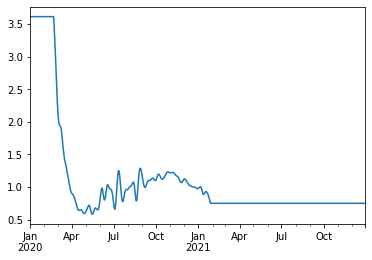

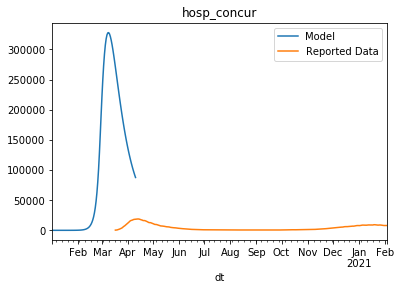

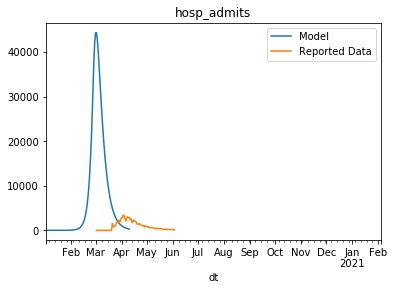

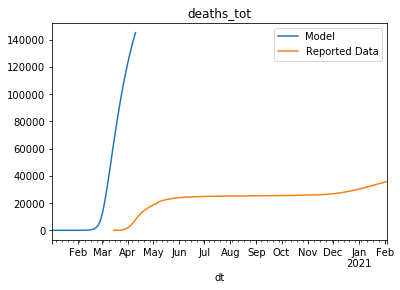

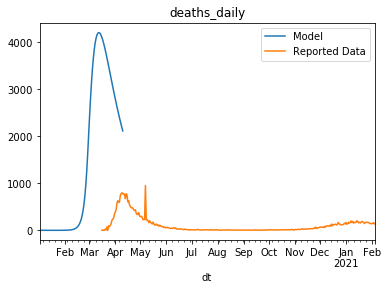

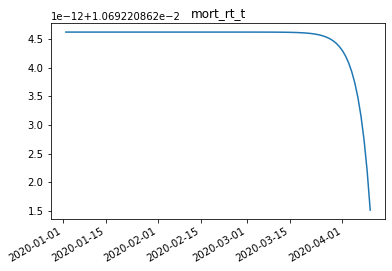

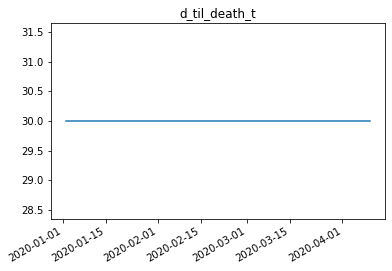

E               5.081538e+00
E_new          -7.315793e-10
I_Mild          7.797817e+02
I_Sev           1.230030e+03
I_Fatal         4.893547e+02
H_Sev           2.527659e+04
H_Fatal         6.237798e+04
H_Admits        2.865481e+02
R               1.921828e+07
D               1.451343e+05
deaths_tot      1.451343e+05
deaths_daily    2.113072e+03
hosp_admits     2.865481e+02
hosp_concur     8.765457e+04
Name: 2020-04-10 00:00:00, dtype: float64


In [40]:
state_code = 'NY'
model_dict = allstate_model_dicts[state_code].copy()
print(f'state_code: {state_code}, model_dict[state_code]: {model_dict["region_code"]}')

days = 100
hrs_per_point = 24
granularity = hrs_per_point/24.
initN = model_dict['tot_pop']

from lmfit import minimize, Parameters, Parameter, report_fit

params = Parameters()
params.add('d_incub', value=model_dict['covid_params']['d_incub'], min=2, max=5)
params.add('d_infect', value=model_dict['covid_params']['d_infect'], min=2, max=7)
params.add('d_to_hosp', value=model_dict['covid_params']['d_to_hosp'], min=2, max=10)
params.add('d_in_hosp', value=model_dict['covid_params']['d_in_hosp'], min=2, max=20)
params.add('d_til_death', value=model_dict['covid_params']['d_til_death'], min=5, max=30)
params.add('d_til_death_curr', value=model_dict['covid_params']['d_til_death'], min=8, max=45)
params.add('mort_rt', value=model_dict['covid_params']['mort_rt'], min=0.001, max=0.04)
params.add('mort_logistic_steepness', value=0.25, min=0.05, max=1)
params.add('mort_rt_curr', value=0.0075, min=0.001, max=0.02)
params.add('hosp_rt', value=model_dict['covid_params']['hosp_rt'], min=0.01, max=0.15)
params.add('start_dt', value=15, min=0, max=100)

initE, E_new = 1e1, 1e1
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initN, initE, E_new,
                      initI_Mild, initI_Sev, initI_Fatal, 
                      initH_Sev, initH_Fatal, initH_Admits, 
                      initR, initD]

tspan = np.arange(0, days, granularity)

data = model_dict['df_hist'][['hosp_concur', 'hosp_admits', 'deaths_daily']].dropna(how='all')

r_ts = model_dict['df_rts']['weighted_average'].dropna()
r_ts = r_ts.loc[r_ts.loc[:'2020-04-15'].idxmax():]
r_ts = r_ts.reindex(pd.date_range('2020-01-01', periods=365*2, freq='1D'))
r_ts = r_ts.interpolate().fillna(method='ffill').fillna(method='bfill')

# df_sol = run_model(params, initial_conditions, tspan, r_ts)
# report_model(r_ts, df_sol, model_dict, params, tspan)

### STEP 1: Find Best Starting Date ###

# First Brute Force
for key in params.keys():
    params[key].set(vary=False)
params['start_dt'].set(vary=True)

result = minimize(error, 
                  params, 
                  args=(initial_conditions, tspan, r_ts.loc[:'2020-07-01'], data.loc[:'2020-07-01'])
                  , method='trust-constr'
                  , nan_policy= 'omit'
                 )
print('==================Found Best Starting Date==================')
display(result)
params['start_dt'].set(value=result.params['start_dt'].value, vary=False)

df_sol = run_model(params, initial_conditions, tspan, r_ts)
report_model(r_ts, df_sol, model_dict, params, tspan)


# ### STEP 2: Find Best Mortality Parameters ###

# for key in params.keys():
#     if key in ['mort_rt', 'mort_rt_curr', 'd_til_death', 'd_til_death_curr']:
#         params[key].set(vary=True)
#     else:
#         params[key].set(vary=False)

# result = minimize(error, 
#                   params, 
#                   args=(initial_conditions, tspan, r_ts, data)
# #                       , method='trust-constr'
#                   , method='brute'
#                   , Ns=3
#                   , keep=5
#                   , nan_policy= 'omit'
#                  )
# print('=======Found Candidates for Best Mortality Parameters=======')
# display(result)

# df_sol = run_model(result.params, initial_conditions, tspan, r_ts)
# report_model(r_ts, df_sol, model_dict, result.params, tspan)

# # Second use leastsq
# best_result = copy.deepcopy(result)
# for cand_rank, candidate in enumerate(result.candidates):
#     print(f'Trying candidate #{cand_rank}.')
#     trial = minimize(error, 
#                   candidate.params, 
#                   args=(initial_conditions, tspan, r_ts, data)
#                   , method='leastsq'
#                   , nan_policy= 'omit'
#                  )
#     if trial.chisqr < best_result.chisqr:
#         print(f'Candidate #{cand_rank} won!')
#         best_result = trial

# display(best_result)

# df_sol = run_model(best_result.params, initial_conditions, tspan, r_ts)
# report_model(r_ts, df_sol, model_dict, best_result.params, tspan)

# params = best_result.params



In [395]:
state_results = {}

In [15]:
# %%time
# state_code = 'NY'
# state_results[state_code] = param_min_sequence(state_code, allstate_model_dicts)

state_code: GA, model_dict[state_code]: GA


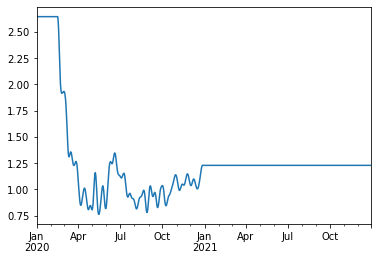

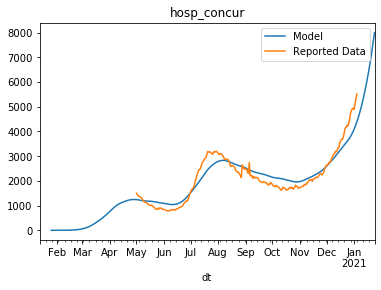

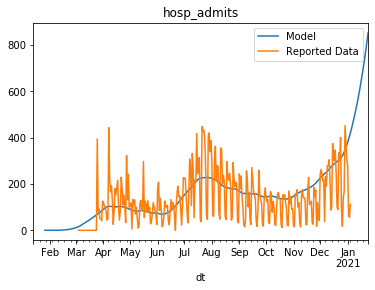

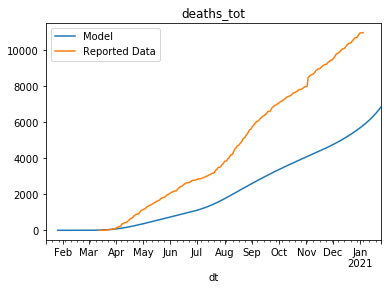

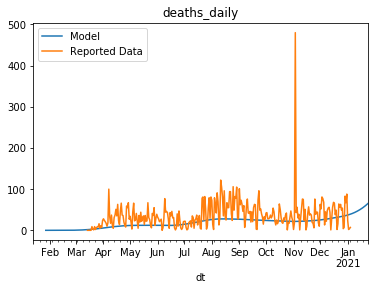

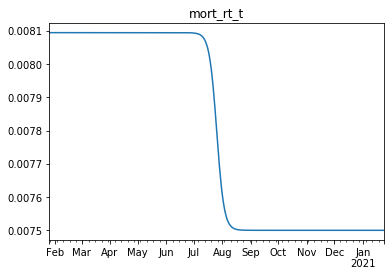

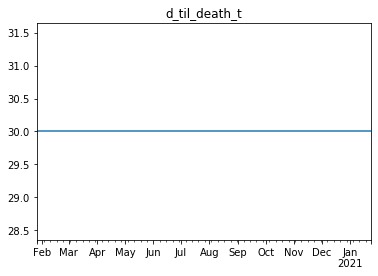

E               6.408143e+04
E_new           2.284436e+04
I_Mild          7.082789e+04
I_Sev           5.282095e+03
I_Fatal         8.960026e+02
H_Sev           5.998674e+03
H_Fatal         1.995810e+03
H_Admits        8.519723e+02
R               1.180180e+06
D               6.838419e+03
deaths_tot      6.838419e+03
deaths_daily    6.551651e+01
hosp_admits     8.519723e+02
hosp_concur     7.994484e+03
Name: 2021-01-24 00:00:00, dtype: float64


/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using q

==================Found Best Starting Date==================


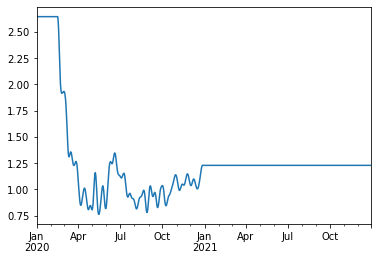

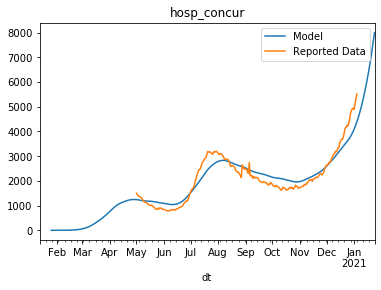

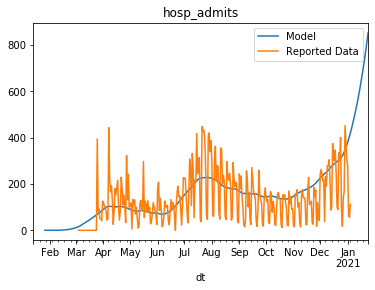

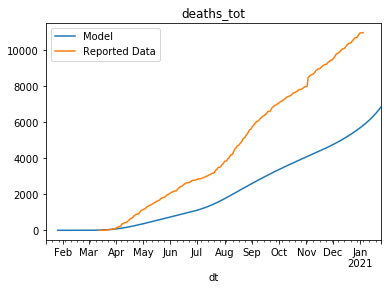

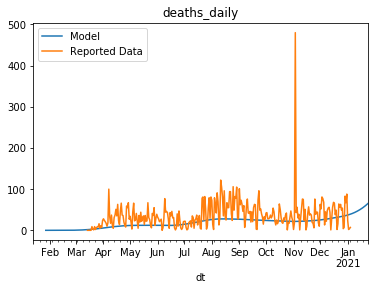

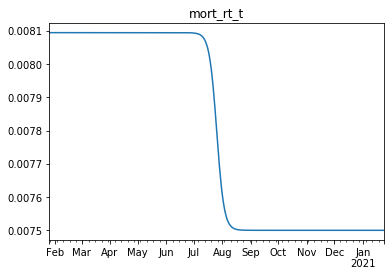

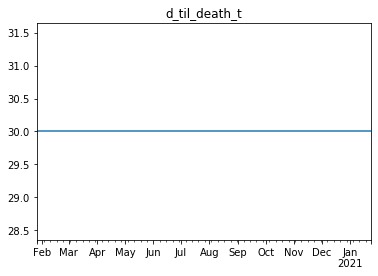

E               6.408143e+04
E_new           2.284436e+04
I_Mild          7.082789e+04
I_Sev           5.282095e+03
I_Fatal         8.960026e+02
H_Sev           5.998674e+03
H_Fatal         1.995810e+03
H_Admits        8.519723e+02
R               1.180180e+06
D               6.838419e+03
deaths_tot      6.838419e+03
deaths_daily    6.551651e+01
hosp_admits     8.519723e+02
hosp_concur     7.994484e+03
Name: 2021-01-24 00:00:00, dtype: float64
=======Found Candidates for Best Mortality Parameters=======


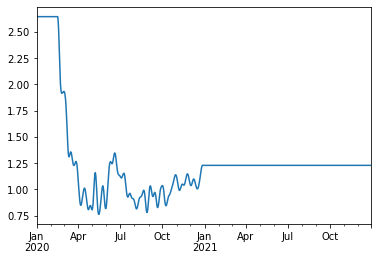

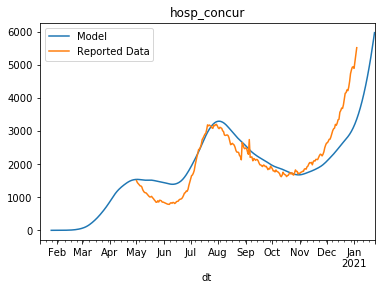

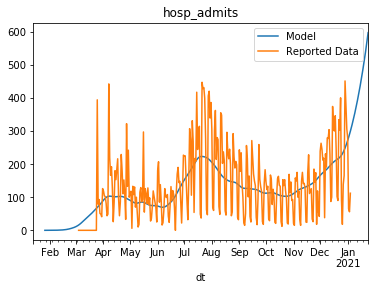

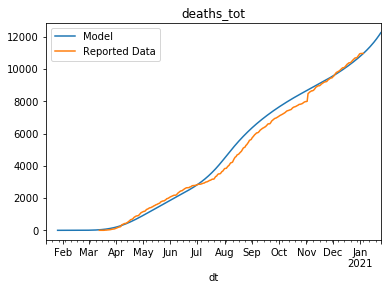

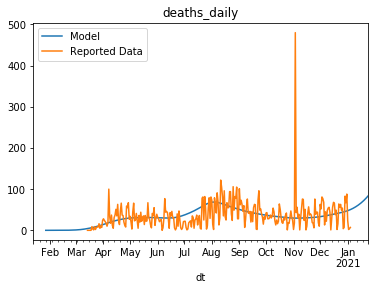

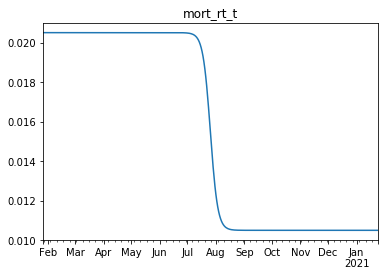

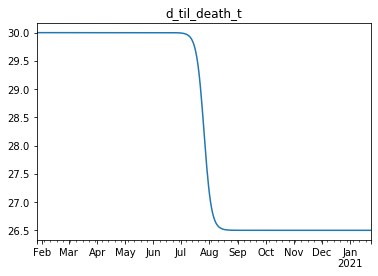

E               5.456024e+04
E_new           1.942089e+04
I_Mild          6.108680e+04
I_Sev           3.251251e+03
I_Fatal         1.073224e+03
H_Sev           3.719051e+03
H_Fatal         2.249112e+03
H_Admits        5.968533e+02
R               1.095588e+06
D               1.225332e+04
deaths_tot      1.225332e+04
deaths_daily    8.359815e+01
hosp_admits     5.968533e+02
hosp_concur     5.968163e+03
Name: 2021-01-24 00:00:00, dtype: float64
Trying candidate #0.
Candidate #0 won!
Trying candidate #1.
Trying candidate #2.
Trying candidate #3.
Trying candidate #4.


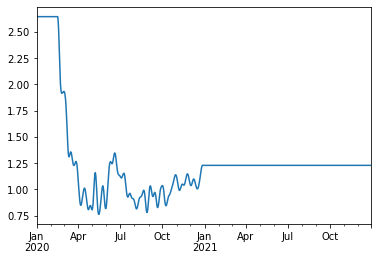

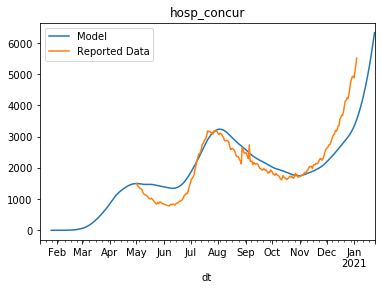

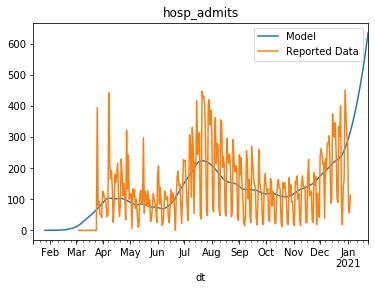

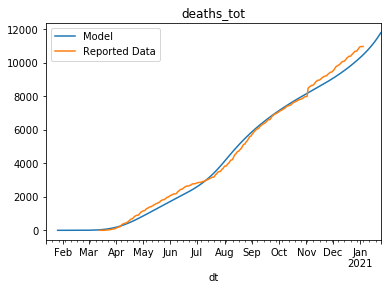

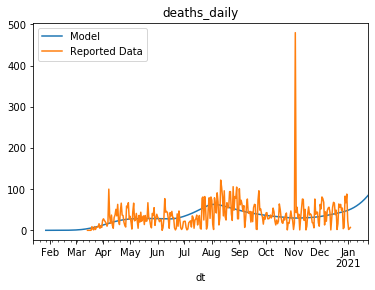

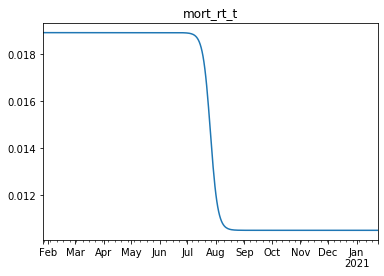

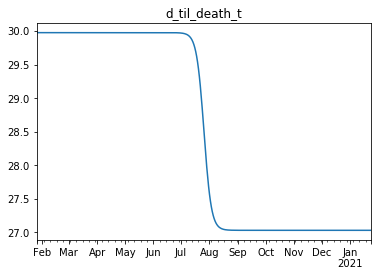

E               5.605832e+04
E_new           1.995920e+04
I_Mild          6.262898e+04
I_Sev           3.503004e+03
I_Fatal         1.101789e+03
H_Sev           4.002148e+03
H_Fatal         2.331993e+03
H_Admits        6.354526e+02
R               1.108661e+06
D               1.179448e+04
deaths_tot      1.179448e+04
deaths_daily    8.497930e+01
hosp_admits     6.354526e+02
hosp_concur     6.334142e+03
Name: 2021-01-24 00:00:00, dtype: float64
====Found Candidates for Best Hospitalization Parameters====


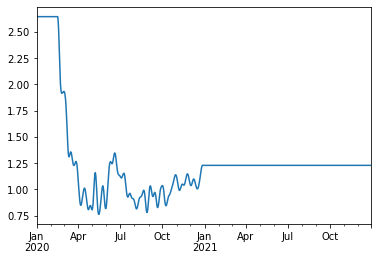

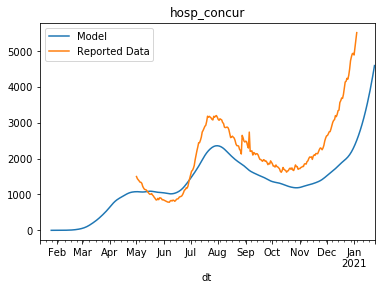

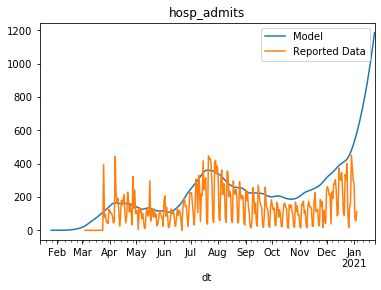

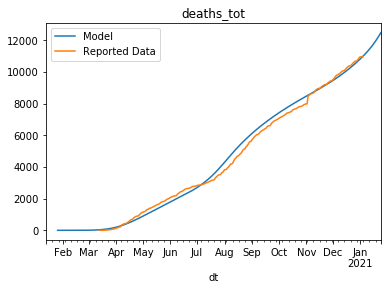

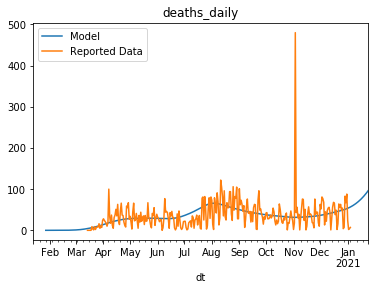

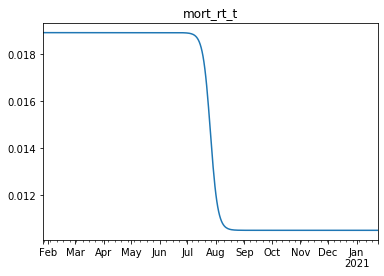

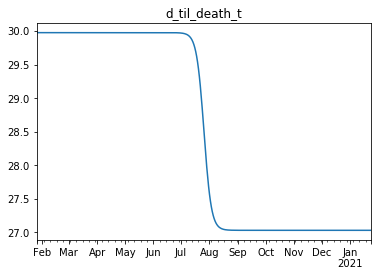

E               6.255579e+04
E_new           2.229123e+04
I_Mild          6.775024e+04
I_Sev           6.292216e+03
I_Fatal         1.081765e+03
H_Sev           1.957559e+03
H_Fatal         2.638229e+03
H_Admits        1.186605e+03
R               1.186847e+06
D               1.248624e+04
deaths_tot      1.248624e+04
deaths_daily    9.609809e+01
hosp_admits     1.186605e+03
hosp_concur     4.595789e+03
Name: 2021-01-24 00:00:00, dtype: float64
Trying candidate #0.
Candidate #0 won!
Trying candidate #1.
Candidate #1 won!
Trying candidate #2.
Candidate #2 won!
Trying candidate #3.
Trying candidate #4.


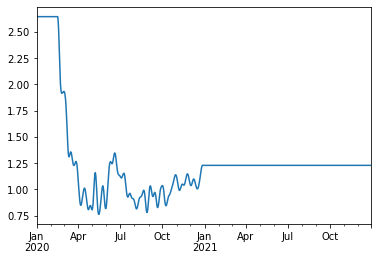

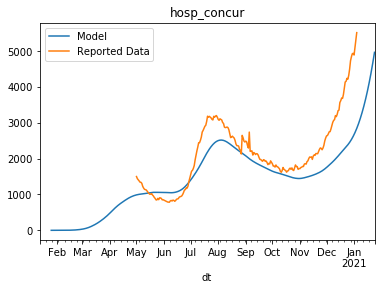

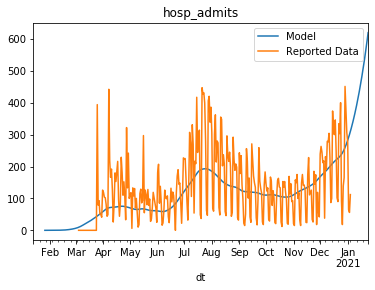

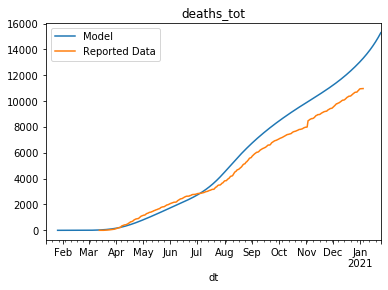

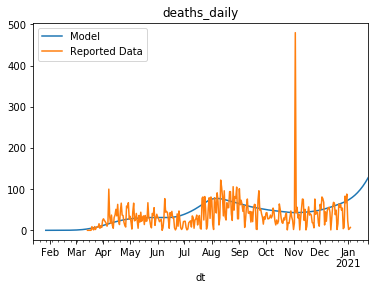

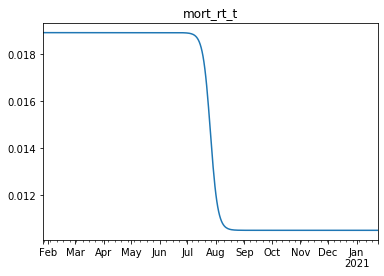

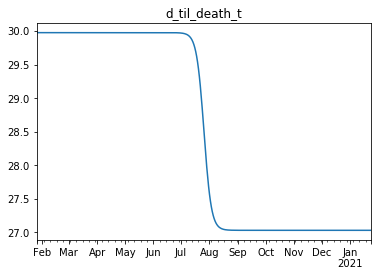

E               9.189661e+04
E_new           3.276424e+04
I_Mild          1.040347e+05
I_Sev           4.049393e+03
I_Fatal         2.367910e+03
H_Sev           1.464876e+03
H_Fatal         3.500390e+03
H_Admits        6.195513e+02
R               1.583315e+06
D               1.529971e+04
deaths_tot      1.529971e+04
deaths_daily    1.275475e+02
hosp_admits     6.195513e+02
hosp_concur     4.965266e+03
Name: 2021-01-24 00:00:00, dtype: float64
CPU times: user 19min 9s, sys: 5.59 s, total: 19min 15s
Wall time: 19min 21s


In [397]:
%%time
state_code = 'GA'
state_results[state_code] = param_min_sequence(state_code, allstate_model_dicts)

state_code: PA, model_dict[state_code]: PA


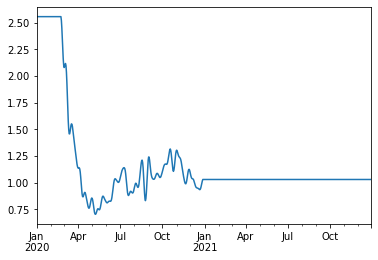

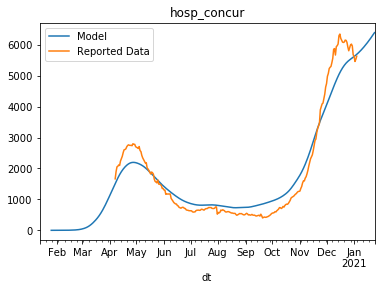

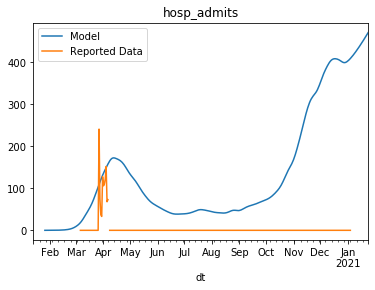

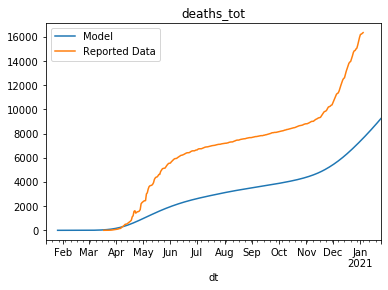

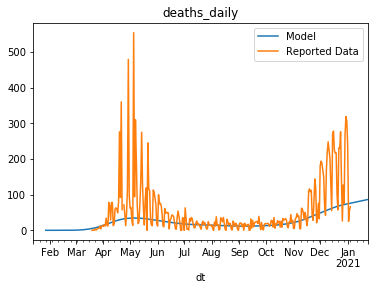

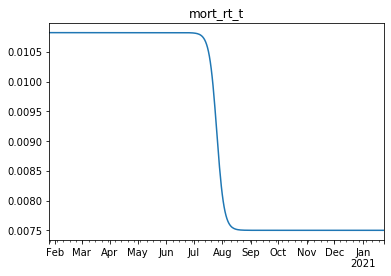

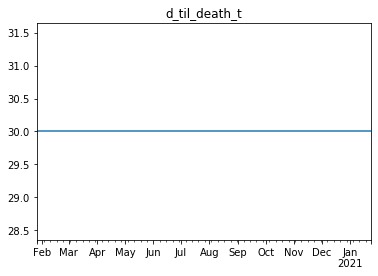

E               4.424796e+04
E_new           1.497121e+04
I_Mild          5.532290e+04
I_Sev           2.583809e+03
I_Fatal         7.356777e+02
H_Sev           3.783393e+03
H_Fatal         2.608772e+03
H_Admits        4.706847e+02
R               1.457678e+06
D               9.245903e+03
deaths_tot      9.245903e+03
deaths_daily    8.665778e+01
hosp_admits     4.706847e+02
hosp_concur     6.392165e+03
Name: 2021-01-24 00:00:00, dtype: float64


/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using q

==================Found Best Starting Date==================


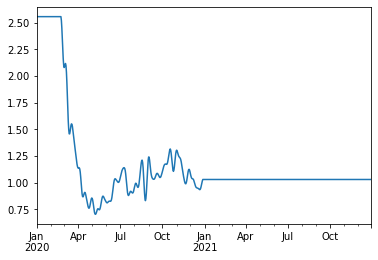

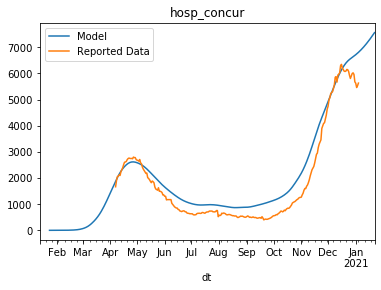

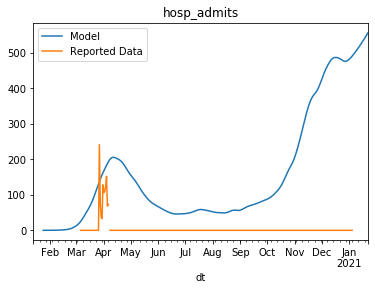

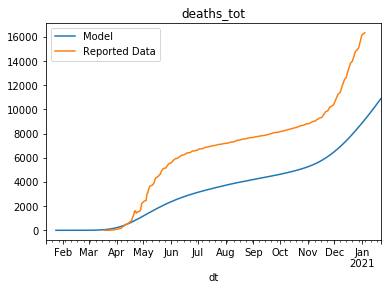

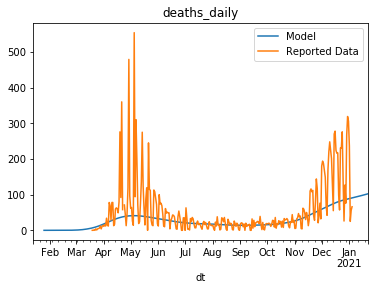

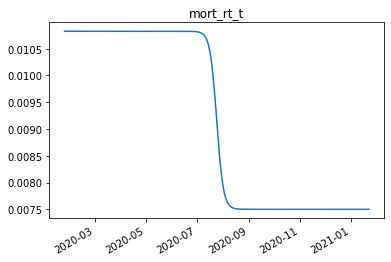

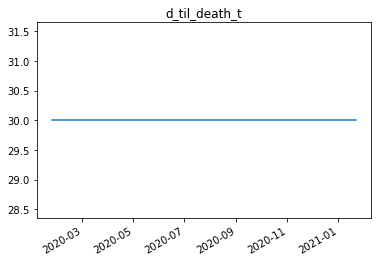

E               5.228162e+04
E_new           1.768940e+04
I_Mild          6.536710e+04
I_Sev           3.053161e+03
I_Fatal         8.693145e+02
H_Sev           4.474639e+03
H_Fatal         3.084372e+03
H_Admits        5.561927e+02
R               1.718767e+06
D               1.090108e+04
deaths_tot      1.090108e+04
deaths_daily    1.024573e+02
hosp_admits     5.561927e+02
hosp_concur     7.559011e+03
Name: 2021-01-22 00:00:00, dtype: float64
=======Found Candidates for Best Mortality Parameters=======


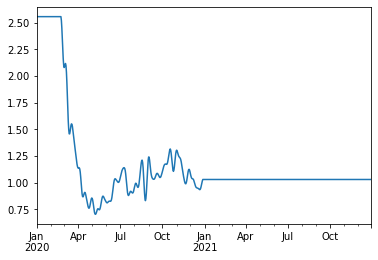

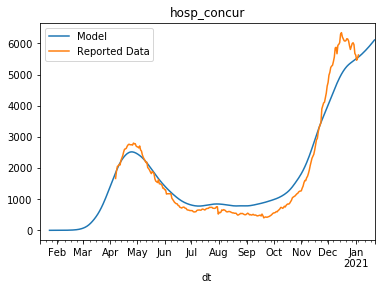

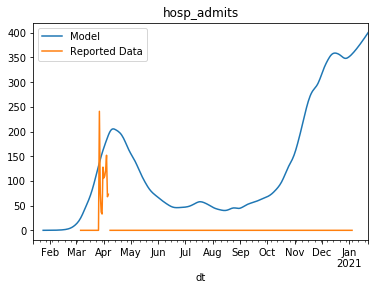

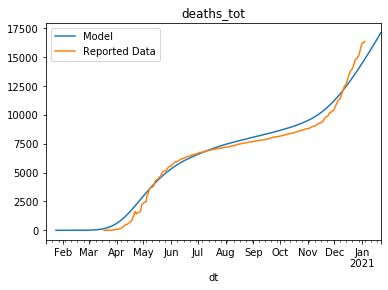

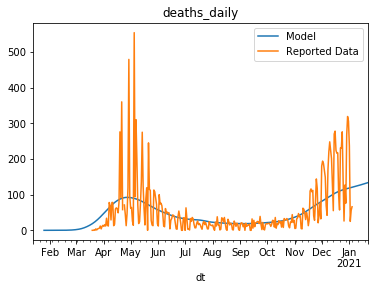

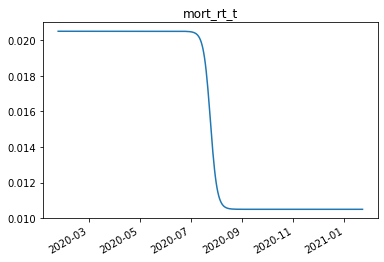

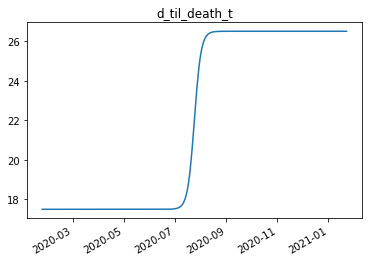

E               4.663104e+04
E_new           1.575701e+04
I_Mild          5.885822e+04
I_Sev           1.730751e+03
I_Fatal         1.090388e+03
H_Sev           2.554558e+03
H_Fatal         3.556354e+03
H_Admits        4.002951e+02
R               1.614998e+06
D               1.712941e+04
deaths_tot      1.712941e+04
deaths_daily    1.337967e+02
hosp_admits     4.002951e+02
hosp_concur     6.110912e+03
Name: 2021-01-22 00:00:00, dtype: float64
Trying candidate #0.
Candidate #0 won!
Trying candidate #1.
Trying candidate #2.
Trying candidate #3.
Trying candidate #4.


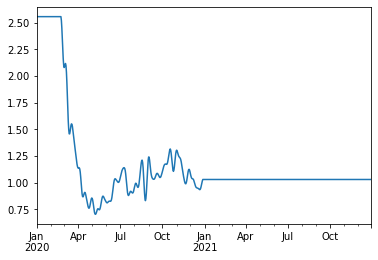

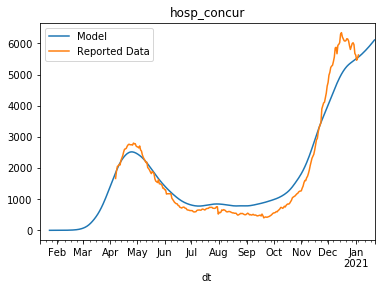

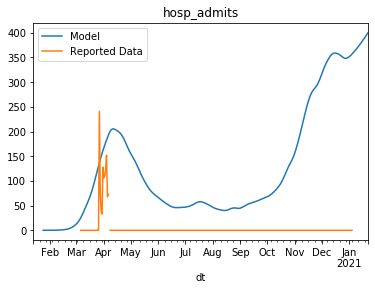

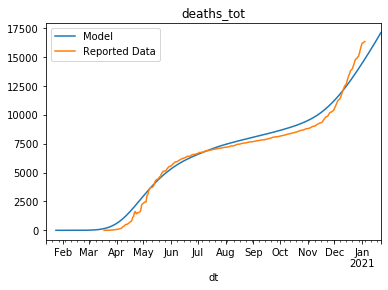

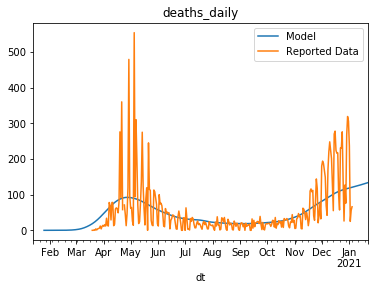

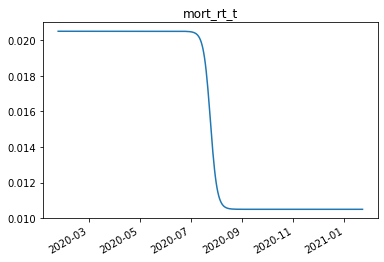

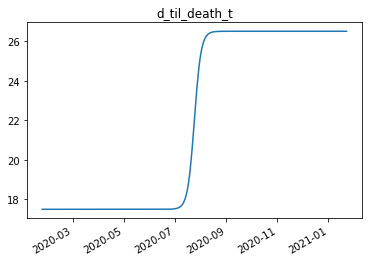

E               4.663105e+04
E_new           1.575701e+04
I_Mild          5.885823e+04
I_Sev           1.730751e+03
I_Fatal         1.090388e+03
H_Sev           2.554559e+03
H_Fatal         3.556355e+03
H_Admits        4.002951e+02
R               1.614998e+06
D               1.712941e+04
deaths_tot      1.712941e+04
deaths_daily    1.337967e+02
hosp_admits     4.002951e+02
hosp_concur     6.110914e+03
Name: 2021-01-22 00:00:00, dtype: float64
====Found Candidates for Best Hospitalization Parameters====


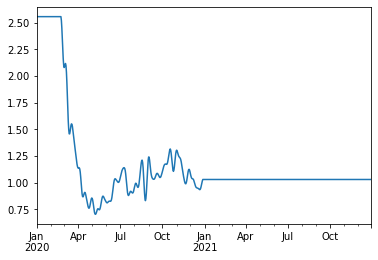

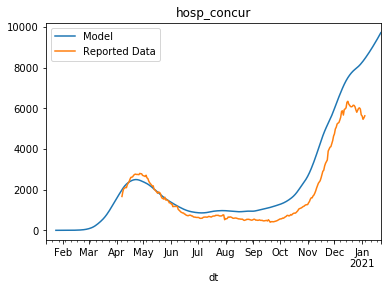

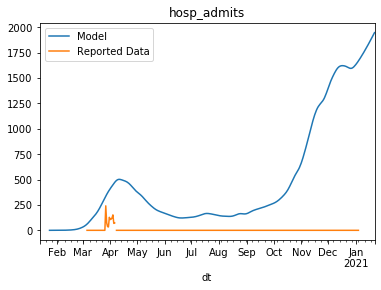

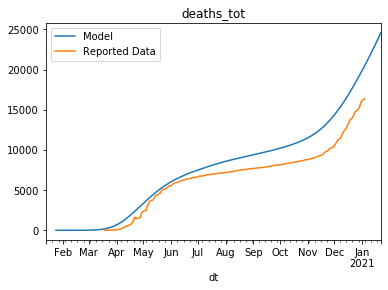

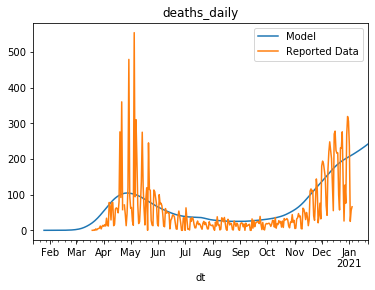

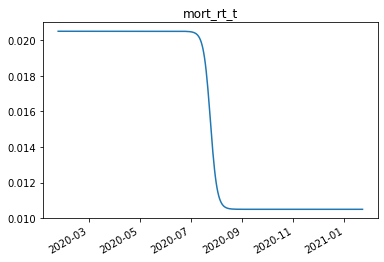

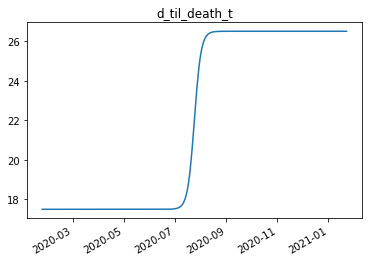

E               8.861527e+04
E_new           3.005857e+04
I_Mild          1.061115e+05
I_Sev           1.001350e+04
I_Fatal         1.767089e+03
H_Sev           3.279896e+03
H_Fatal         6.440934e+03
H_Admits        1.946221e+03
R               2.539719e+06
D               2.460752e+04
deaths_tot      2.460752e+04
deaths_daily    2.420873e+02
hosp_admits     1.946221e+03
hosp_concur     9.720830e+03
Name: 2021-01-22 00:00:00, dtype: float64
Trying candidate #0.
Candidate #0 won!
Trying candidate #1.
Candidate #1 won!
Trying candidate #2.
Trying candidate #3.
Trying candidate #4.


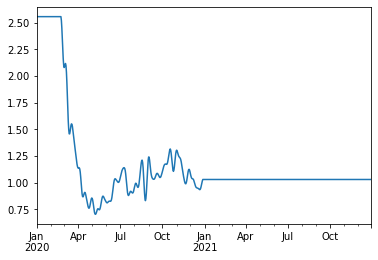

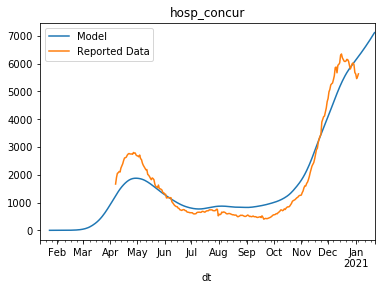

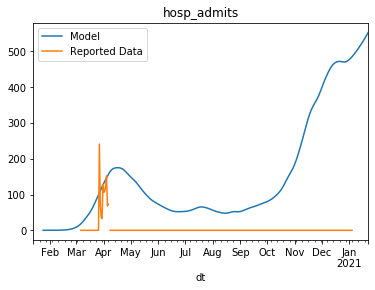

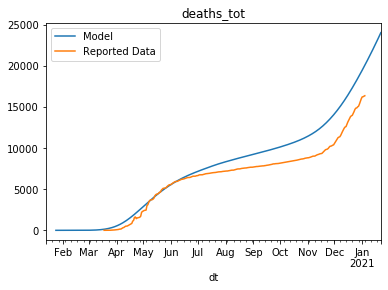

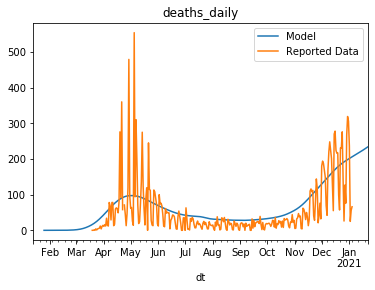

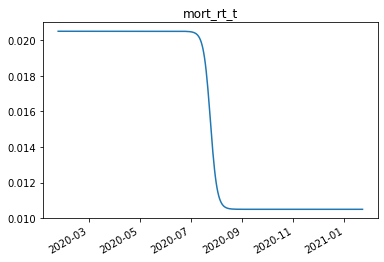

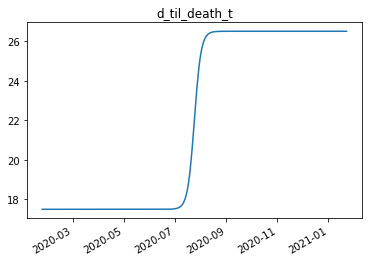

E               8.671826e+04
E_new           2.938008e+04
I_Mild          1.095920e+05
I_Sev           2.757021e+03
I_Fatal         2.811153e+03
H_Sev           8.800904e+02
H_Fatal         6.233418e+03
H_Admits        5.524356e+02
R               2.572350e+06
D               2.403316e+04
deaths_tot      2.403316e+04
deaths_daily    2.343606e+02
hosp_admits     5.524356e+02
hosp_concur     7.113508e+03
Name: 2021-01-22 00:00:00, dtype: float64
CPU times: user 11min 39s, sys: 2.33 s, total: 11min 42s
Wall time: 11min 44s


In [398]:
%%time
state_code = 'PA'
state_results[state_code] = param_min_sequence(state_code, allstate_model_dicts)

state_code: CA, model_dict[state_code]: CA


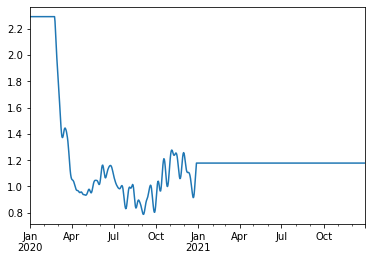

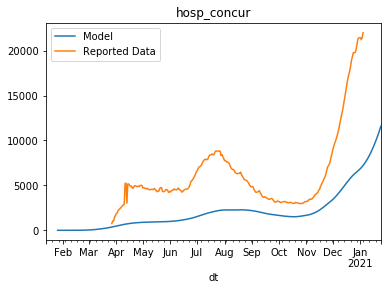

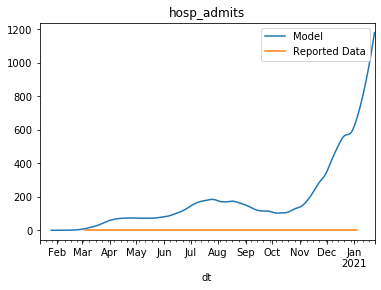

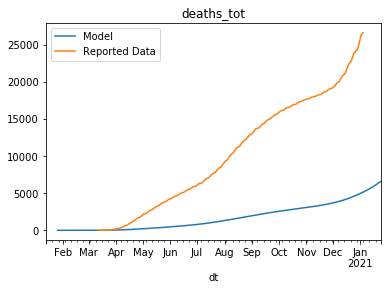

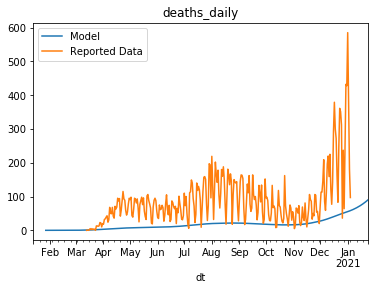

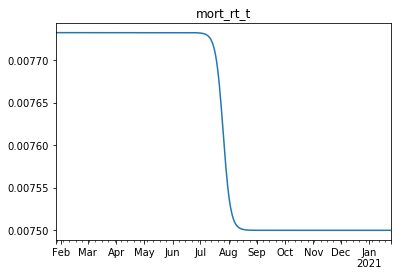

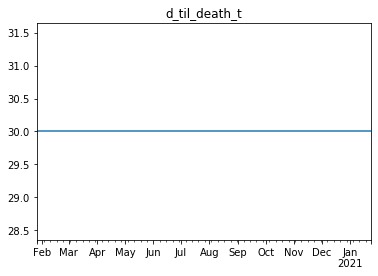

E               7.798571e+04
E_new           2.749390e+04
I_Mild          8.770548e+04
I_Sev           7.365530e+03
I_Fatal         1.130581e+03
H_Sev           8.845200e+03
H_Fatal         2.746442e+03
H_Admits        1.178871e+03
R               1.275380e+06
D               6.604825e+03
deaths_tot      6.604825e+03
deaths_daily    9.039552e+01
hosp_admits     1.178871e+03
hosp_concur     1.159164e+04
Name: 2021-01-24 00:00:00, dtype: float64


/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/mdonnelly/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


==================Found Best Starting Date==================


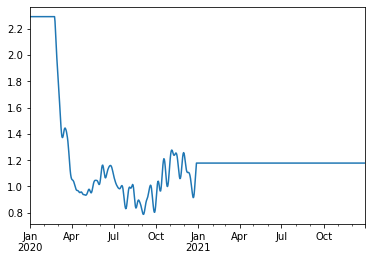

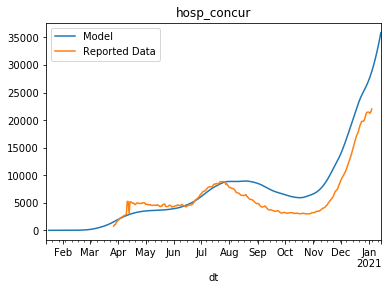

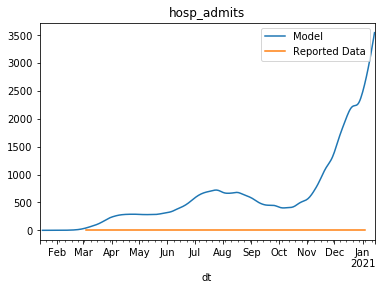

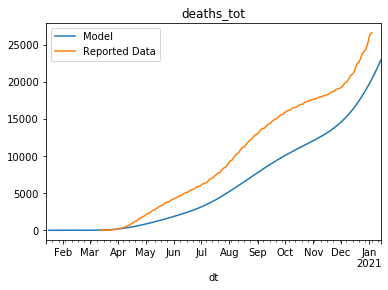

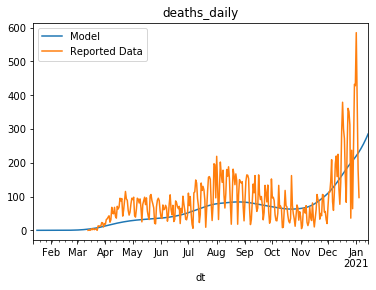

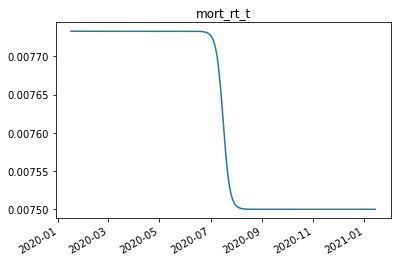

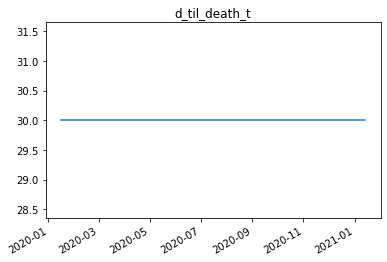

E               2.339171e+05
E_new           8.247041e+04
I_Mild          2.630312e+05
I_Sev           2.213841e+04
I_Fatal         3.398164e+03
H_Sev           2.720570e+04
H_Fatal         8.654072e+03
H_Admits        3.544787e+03
R               4.293757e+06
D               2.295945e+04
deaths_tot      2.295945e+04
deaths_daily    2.852281e+02
hosp_admits     3.544787e+03
hosp_concur     3.585977e+04
Name: 2021-01-14 00:00:00, dtype: float64
=======Found Candidates for Best Mortality Parameters=======


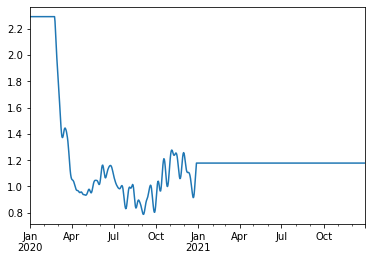

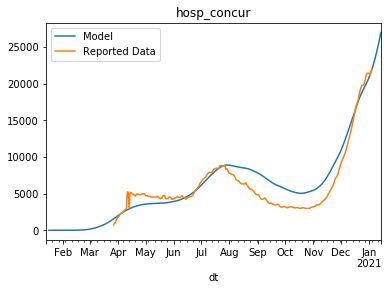

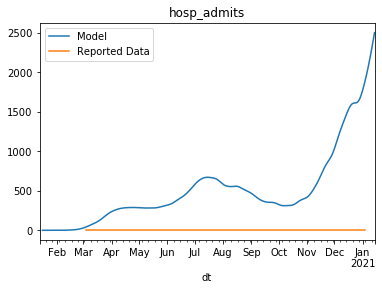

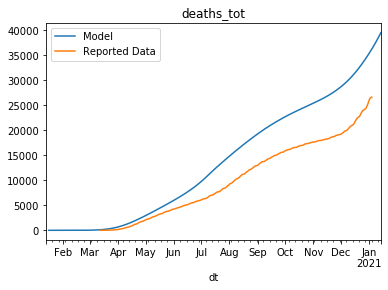

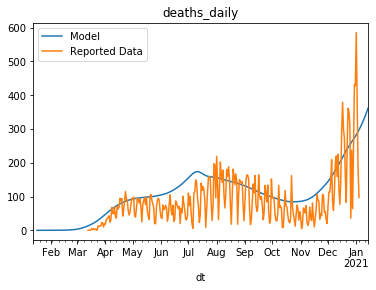

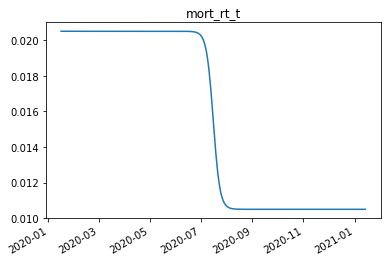

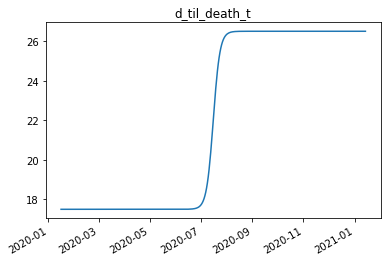

E               1.981829e+05
E_new           6.975878e+04
I_Mild          2.258915e+05
I_Sev           1.393056e+04
I_Fatal         4.052518e+03
H_Sev           1.726596e+04
H_Fatal         9.692951e+03
H_Admits        2.498532e+03
R               3.932335e+06
D               3.952981e+04
deaths_tot      3.952981e+04
deaths_daily    3.618020e+02
hosp_admits     2.498532e+03
hosp_concur     2.695891e+04
Name: 2021-01-14 00:00:00, dtype: float64
Trying candidate #0.
Trying candidate #1.
Trying candidate #2.
Trying candidate #3.
Trying candidate #4.


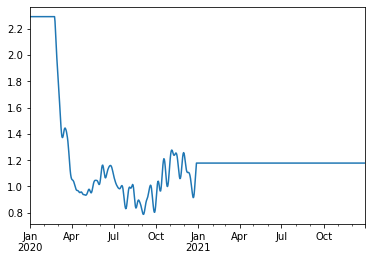

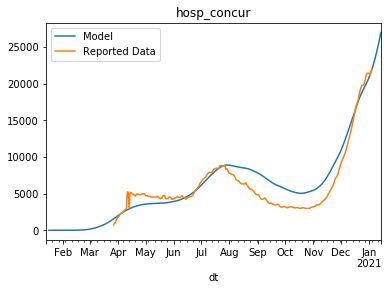

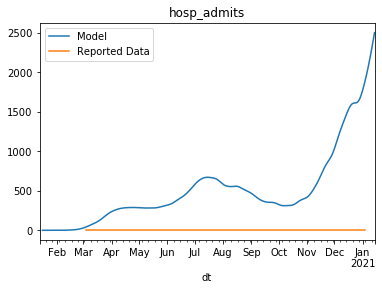

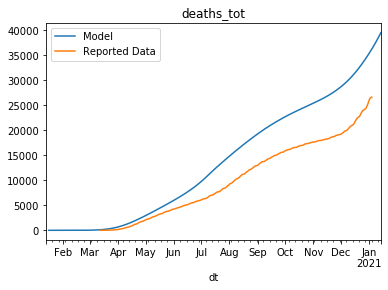

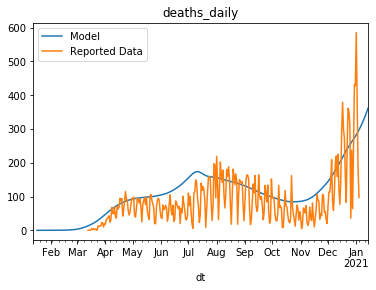

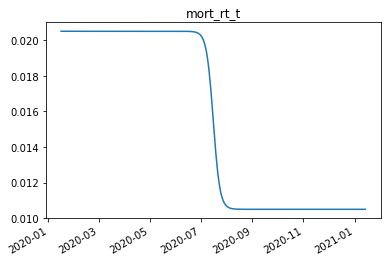

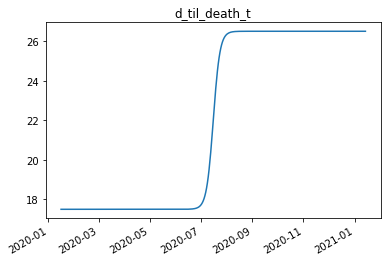

E               1.981829e+05
E_new           6.975878e+04
I_Mild          2.258915e+05
I_Sev           1.393056e+04
I_Fatal         4.052518e+03
H_Sev           1.726596e+04
H_Fatal         9.692951e+03
H_Admits        2.498532e+03
R               3.932335e+06
D               3.952981e+04
deaths_tot      3.952981e+04
deaths_daily    3.618020e+02
hosp_admits     2.498532e+03
hosp_concur     2.695891e+04
Name: 2021-01-14 00:00:00, dtype: float64
====Found Candidates for Best Hospitalization Parameters====


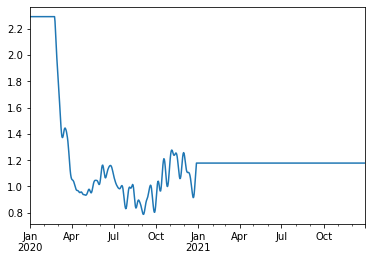

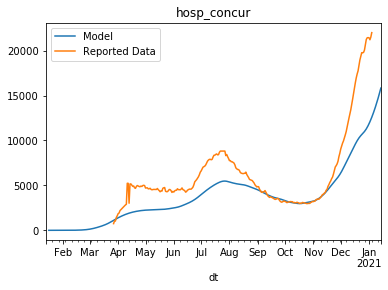

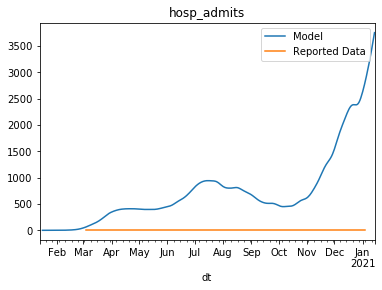

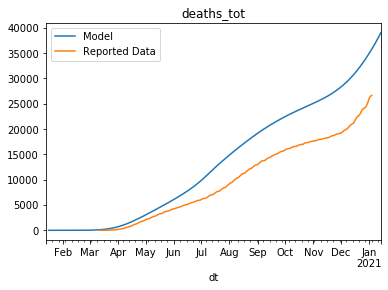

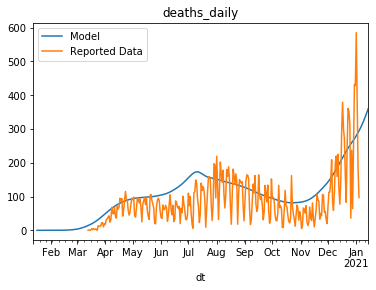

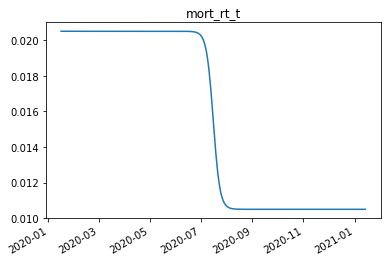

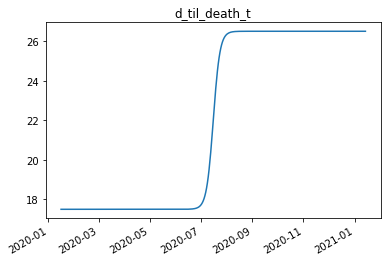

E               1.937900e+05
E_new           6.822515e+04
I_Mild          2.153868e+05
I_Sev           1.967860e+04
I_Fatal         3.472693e+03
H_Sev           6.205849e+03
H_Fatal         9.628900e+03
H_Admits        3.751304e+03
R               3.853059e+06
D               3.906015e+04
deaths_tot      3.906015e+04
deaths_daily    3.593429e+02
hosp_admits     3.751304e+03
hosp_concur     1.583475e+04
Name: 2021-01-14 00:00:00, dtype: float64
Trying candidate #0.
Candidate #0 won!
Trying candidate #1.
Trying candidate #2.
Trying candidate #3.
Trying candidate #4.


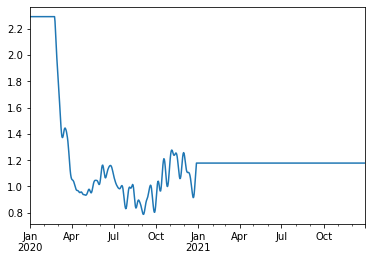

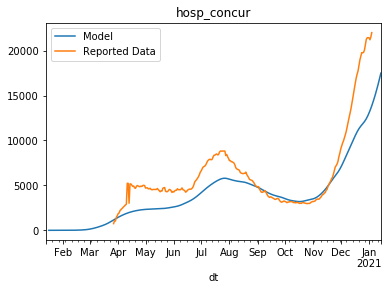

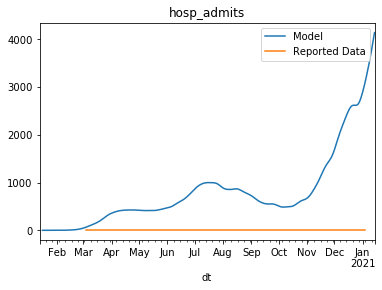

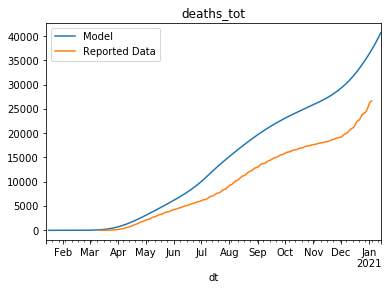

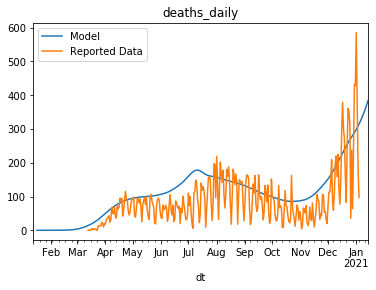

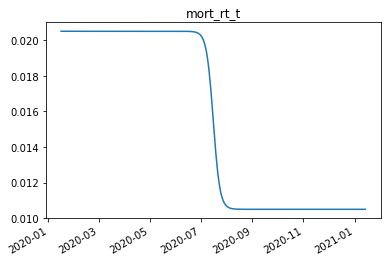

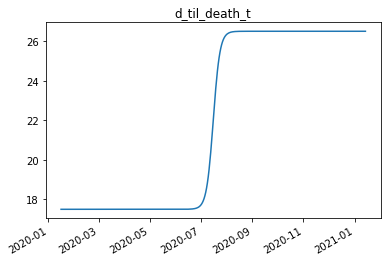

E               2.084406e+05
E_new           7.340865e+04
I_Mild          2.310332e+05
I_Sev           2.192727e+04
I_Fatal         3.749521e+03
H_Sev           7.194026e+03
H_Fatal         1.030330e+04
H_Admits        4.136403e+03
R               4.059338e+06
D               4.071412e+04
deaths_tot      4.071412e+04
deaths_daily    3.844722e+02
hosp_admits     4.136403e+03
hosp_concur     1.749733e+04
Name: 2021-01-14 00:00:00, dtype: float64
CPU times: user 12min 27s, sys: 2.31 s, total: 12min 29s
Wall time: 12min 32s


In [399]:
%%time
state_code = 'CA'
state_results[state_code] = param_min_sequence(state_code, allstate_model_dicts)

In [309]:

for key in params.keys():
    if key in ['hosp_rt', 'mort_rt', 'mort_rt_curr', 'd_til_death', 'd_to_hosp', 'd_in_hosp']:
        params[key].set(vary=True)
    else:
        params[key].set(vary=False)
        
# for n in range(1,8):
#     print(n)
#     %time trial = minimize(error, \
#                        params, \
#                        args=(initial_conditions, tspan, r_ts, data), \
#                        method='brute', max_nfev=100,  Ns=n, nan_policy='omit')
#     print(f'hosp_rt = {trial.params["hosp_rt"].value:.2f}')
#     print(f'd_to_hosp = {trial.params["d_to_hosp"].value:.2f}')
#     print(f'd_in_hosp = {trial.params["d_in_hosp"].value:.2f}')
%time trial = minimize(error, \
                       params, \
                       args=(initial_conditions, tspan, r_ts, data), \
                       method='brute', max_nfev=100, nan_policy='omit')
# trial
    

CPU times: user 2min 13s, sys: 1.48 s, total: 2min 14s
Wall time: 2min 14s


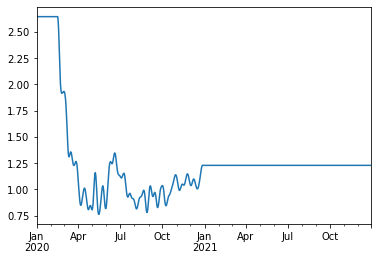

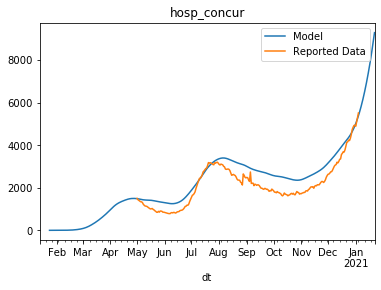

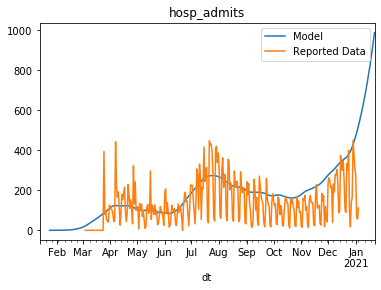

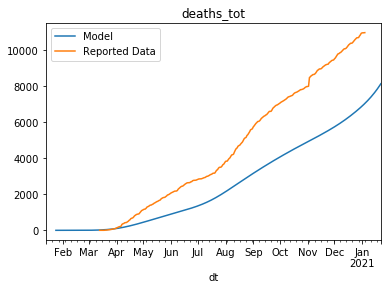

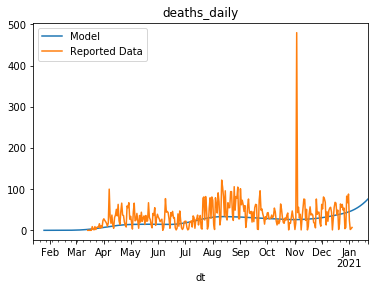

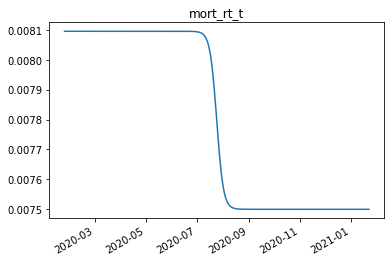

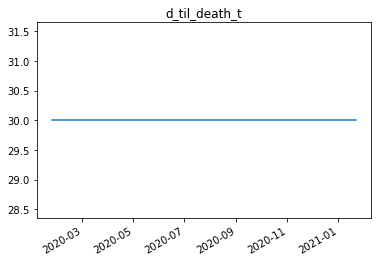

E               7.428265e+04
E_new           2.648101e+04
I_Mild          8.210282e+04
I_Sev           6.123248e+03
I_Fatal         1.038688e+03
H_Sev           6.961755e+03
H_Fatal         2.325929e+03
H_Admits        9.876555e+02
R               1.396665e+06
D               8.135929e+03
deaths_tot      8.135929e+03
deaths_daily    7.636647e+01
hosp_admits     9.876555e+02
hosp_concur     9.287684e+03
Name: 2021-01-22 00:00:00, dtype: float64


In [308]:
display(trial)
df_sol = run_model(trial.params, initial_conditions, tspan, r_ts)
report_model(r_ts, df_sol, model_dict, trial.params, tspan)

In [102]:
minimize_methods = ['leastsq', 'least_squares', 'differential_evolution', 'brute', 'basinhopping', 
                    'ampgo', 'nelder', 'lbfgsb', 'powell', 'cg', 'newton', 'cobyla', 'bfgs', 'tnc', 
                    'trust-ncg', 'trust-exact', 'trust-krylov', 'trust-constr', 'dogleg', 'slsqp', 
                    'emcee', 'shgo', 'dual_annealing']


for method in minimize_methods: 
    print(f'========{method}========')
    try:
        %time trial = minimize(error, \
                       result.candidates[0].params, \
                       args=(initial_conditions, tspan, r_ts, data), \
                       method=method, max_nfev=100)
        print(f'start_dt = {trial.params["start_dt"].value:.2f}')
    except:
        print('THERE WAS AN ERROR')
    print(f'========================')

========leastsq========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========least_squares========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========differential_evolution========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========brute========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========basinhopping========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========ampgo========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========nelder========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========lbfgsb========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========powell========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========cg========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========newton========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========cobyla========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========bfgs========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========tnc========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========trust-ncg========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========trust-exact========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========trust-krylov========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========trust-constr========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========dogleg========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========slsqp========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========emcee========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========shgo========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34
========dual_annealing========


AttributeError: 'MinimizerResult' object has no attribute 'candidates'

start_dt = 22.34


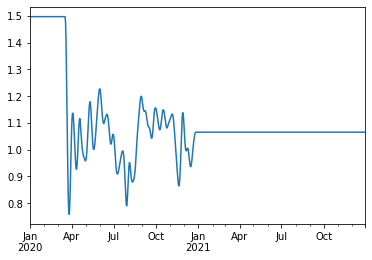

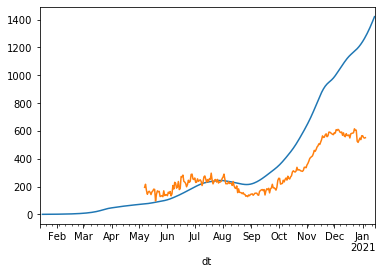

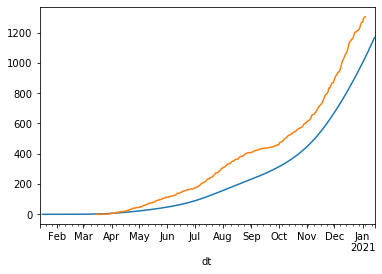

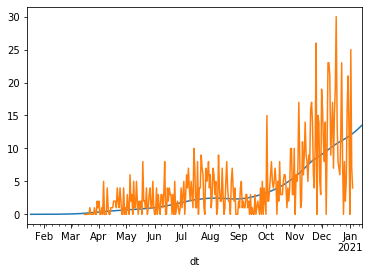

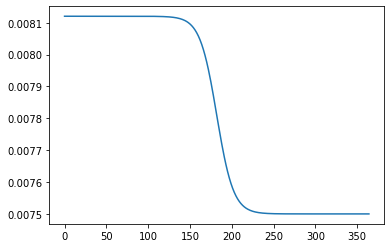

E                 7866.187106
E_new             2696.046465
I_Mild            9409.890930
I_Sev              733.589923
I_Fatal            125.251754
H_Sev             1014.380763
H_Fatal            407.113169
H_Admits           120.983243
R               211588.750733
D                 1166.837083
deaths_tot        1166.837083
deaths_daily        13.499000
hosp_admits        120.983243
hosp_concur       1421.493932
Name: 2021-01-14 00:00:00, dtype: float64


In [99]:
thisone = minimize(error, 
                   result.candidates[0].params,
                   args=(initial_conditions, tspan, r_ts, data), 
                   method='trust-constr', max_nfev=100)

report_model(r_ts, 
             run_model(thisone.params, initial_conditions, tspan, r_ts), 
             model_dict, thisone.params, tspan)

best_result

## SciPy Model

In [20]:
# from scipy.optimize import minimize, rosen, rosen_der


## Basic Daily Cohort Model

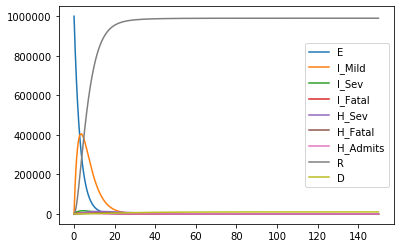

E           1.962320e-16
I_Mild      2.008308e-10
I_Sev       2.608757e-05
I_Fatal     8.695856e-06
H_Sev       1.361368e-01
H_Fatal     3.046646e+00
H_Admits    5.796183e-06
R           9.899999e+05
D           9.996953e+03
Name: 149.95833333333331, dtype: float64


In [21]:
# where mu = 1 / d_til_death
# mu*x / (mu*x + gamma) = mort_rt
# mux = mort * mux + mort*gamma
# mux - mort* mux = mort*gamma
# mux * (1 - mort) = mort* gamma
# x * (mu - mort*mu) = mort * gamma
# x = (mort_rt * gamma) / (mu - mort_rt * mu)
# x = (mort_rt * gamma) / mu*(1 - mort_rt)
# x = d_til_death * mort_rt * gamma / (1-mort_rt)

def cohort_ode_model(z, t_, covid_params):
    E, I_Mild, I_Sev, I_Fatal, H_Sev, H_Fatal, H_Admits, R, D = z
    ## FLOWS ##
    
    _sigma = 1/covid_params['d_incub']
    _gamma = 1/covid_params['d_infect']
    _nu = 1/covid_params['d_to_hosp']
    _rho = 1/covid_params['d_in_hosp']
    _mu = 1/covid_params['d_til_death']
    
    p_fatal = covid_params['mort_rt']
    p_recov_sev = covid_params['hosp_rt'] - covid_params['mort_rt']
    p_recov_mild = 1 - covid_params['hosp_rt']

    dEdt = -_sigma*E
    
    dI_Milddt = p_recov_mild*_sigma*E - _gamma*I_Mild
    dI_Sevdt = p_recov_sev*_sigma*E - _nu*I_Sev
    dI_Fataldt = p_fatal*_sigma*E - _nu*I_Fatal
    
    dH_Sevdt = _nu*I_Sev - _rho*H_Sev
    dH_Fataldt = _nu*I_Fatal - _mu*H_Fatal
    H_Admits = _nu*I_Sev + _nu*I_Fatal - H_Admits
    
    dRdt = _gamma*I_Mild + _rho*H_Sev
    dDdt = _mu*H_Fatal
    return [dEdt, dI_Milddt, dI_Sevdt, dI_Fataldt, dH_Sevdt, dH_Fataldt, H_Admits, dRdt, dDdt]

days = 150
hrs_per_point = 1.
granularity = hrs_per_point/24.
# initN = 1e8
initE = 1e6
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initE, initI_Mild, initI_Sev, initI_Fatal, initH_Sev, initH_Fatal, initH_Admits, initR, initD]

tspan = np.arange(0, days, granularity)
sol = odeint(cohort_ode_model, initial_conditions, tspan, args=(covid_params,))

df_sol = pd.DataFrame(sol, 
                      columns=['E', 'I_Mild', 'I_Sev', 'I_Fatal', 'H_Sev', 'H_Fatal', 'H_Admits', 'R','D'], 
                      index=tspan)
df_sol.plot(); plt.show()
df_sol.R.diff().plot; plt.show()

print(df_sol.iloc[-1])


In [22]:
%%timeit
sol = odeint(cohort_ode_model, initial_conditions, tspan, args=(covid_params,))

5.5 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


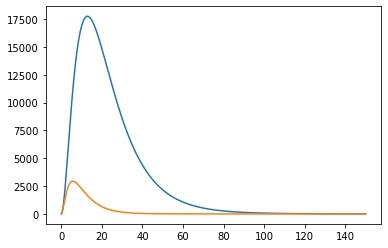

In [23]:
# df_sol[['H_Sev', 'H_Fatal']].div(df_sol[['H_Sev', 'H_Fatal']].sum(axis=1), axis=0).plot()
ax = df_sol[['H_Sev', 'H_Fatal']].sum(axis=1).plot()
df_sol.H_Admits.plot(ax=ax)


In [24]:
days = 365
# initN = 1e8
initE = 1
initI = 1
initH = 0
initR = 0
initD = 0
initial_conditions = [initE, initI, initH, initR, initD]

tspan = np.arange(0, days, 1)
sol = ode_solver(tspan, initial_conditions, covid_params)
E, I, H, R, D, d_hosp_admits = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]

KeyError: 'beta'

In [ ]:
# function that returns dy/dt
def model(y,t):
    if t >5:
#         k = 0.3
#         dydt = -k * y
        dydt = gamma.pdf(t, 5)
    else:
        dydt = 0
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20, 100)

# solve ODE
y = odeint(model,y0,t)

plt.plot(t,y)

In [ ]:
%%timeit
y = odeint(model,y0,t)

In [ ]:
%%timeit 
y = [5]
for t_ in t:

    dydt = model(y[-1], t_)

    y_ = y[-1] + dydt

    y = y + [y_]

# y[-1]

In [ ]:
plt.plot(t,y[1:])

In [ ]:
allstate_model_dicts = {}
df_rts_allregs = pd.DataFrame()
df_wavg_rt_conf_allregs = pd.DataFrame()

for state in l_states_to_fore:
    print(state)
    
    model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
    
    this_reg_df_rts = pd.DataFrame(model_dict['df_rts'].stack(), columns=[state])
    this_reg_df_wavg = pd.DataFrame(
        model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=[state])

    df_rts_allregs = pd.concat([df_rts_allregs, this_reg_df_rts], axis=1)
    df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)

    try:
        first_guess = df_prevfore_allstates[state].first_valid_index()[0]
    except:
        first_guess = pd.Timestamp('2020-02-17')

    model_dict = model_find_start(first_guess, model_dict)
    df_agg = model_dict['df_agg']
    df_all_cohorts = model_dict['df_all_cohorts']

    print('Peak Hospitalization Date: ', df_agg.hospitalized.idxmax().strftime("%d %b, %Y"))
    print('Peak Hospitalization #: {:.0f}'.format(df_agg.hospitalized.max()))
    print('Peak ICU #: {:.0f}'.format(df_agg.icu.max()))
    print('Peak Ventilator #: {:.0f}'.format(df_agg.vent.max()))

    model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'

    allstate_model_dicts[state] = model_dict
    df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_agg.stack(), columns=[state])], axis=1)

#######################

### Add US Country Level Entries Before Saving ###
df_fore_us = df_fore_allstates.sum(axis=1, skipna=True).unstack('metric').dropna(how='all')
tot_pop = df_fore_us[['susceptible', 'deaths', 'exposed', 'hospitalized', 'infectious', 'recovered']].sum(axis=1)
max_tot_pop = tot_pop.max()
df_fore_us.loc[tot_pop<max_tot_pop, 'susceptible'] = df_fore_us['susceptible'] + (max_tot_pop - tot_pop)
df_fore_allstates = pd.concat([df_fore_allstates,pd.DataFrame(df_fore_us.stack(), columns=['US'])], axis=1)

model_dict = make_model_dict_us(df_census, df_st_testing_fmt, covid_params, d_to_forecast = 75,
                               df_mvmt=df_goog_mob_us, df_interventions=df_interventions)
model_dict['df_agg'] = df_fore_us
model_dict['chart_title'] = r'No Change in Future $R_{t}$ Until 20% Hospital Capacity Trigger'
allstate_model_dicts['US'] = model_dict

this_reg_df_wavg = pd.DataFrame(
    model_dict['df_rts_conf'].sort_index().unstack('metric')['weighted_average'].stack(), columns=['US'])
df_wavg_rt_conf_allregs = pd.concat([df_wavg_rt_conf_allregs, this_reg_df_wavg], axis=1)
###################################################

### Save Output ###
# df_rts_allregs.index.names = ['dt','metric']

# df_wavg_rt_conf_allregs.unstack('metric').to_csv(
#     './output/df_wavg_rt_conf_allregs_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_wavg_rt_conf_allregs.to_pickle('./output/df_wavg_rt_conf_allregs_{}.pkl'.format(
#     pd.Timestamp.today().strftime("%Y%m%d")))

# df_fore_allstates.unstack('metric').to_csv(
#     './output/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.unstack('metric').to_csv(
#     '../COVIDoutlook/download/df_fore_allstates_{}.csv'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#     encoding='utf-8')
# df_fore_allstates.to_pickle('./output/df_fore_allstates_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d")))

# asmd_filename = './output/allstate_model_dicts_{}.pkl'.format(pd.Timestamp.today().strftime("%Y%m%d"))

# df_interventions.to_csv('../COVIDoutlook/download/df_interventions.csv', encoding='utf-8')

# with open(asmd_filename, 'wb') as handle:
#     pickle.dump(allstate_model_dicts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# os.system('say -v "Victoria" "Your forecasts are ready."')

######################

# os.system('python web_gen_covidoutlook.py &') # 'python web_gen_covidoutlook.py 2>&1 | tee -a web_gen_covidoutlook.log &'
# os.system('python web_gen_personal.py &')

In [ ]:
model_dict = make_model_dict_state('NY',abbrev_us_state,df_census,
    df_st_testing_fmt,
    covid_params,
    d_to_forecast=75,
    df_mvmt=df_goog_mob_state)
ax = ch_rt_confid(model_dict)

In [ ]:
from coronita_chart_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

### Settings and Functions for Personal Website ###
plt.style.use('ggplot')

def footnote_str_maker():
    footnote_str = 'www.COVIDoutlook.info | twtr: @COVIDoutlook\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str


def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                            text='<a href="http://{0}">{0}</a> | twtr: <a href="https://twitter.com/COVIDoutlook">@COVIDoutlook</a> | '.format(
                           'www.COVIDoutlook.info')
                          ),
                      dict(x = 0, y = -0.09,
                           xref='paper', yref='paper', font_size=10, showarrow=False,
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig
d_chart_fns = {'ch_rt_confid': ch_rt_confid,
 'ch_positivetests': ch_positivetests,
 'ch_totaltests': ch_totaltests,
 'ch_postestshare': ch_postestshare,
 'ch_detection_rt': ch_detection_rt,
 'ch_googmvmt': ch_googmvmt,
 'ch_exposed_infectious': ch_exposed_infectious,
 'ch_hosp': ch_hosp,
 'ch_population_share': ch_population_share,
 'ch_cumul_infections': ch_cumul_infections,
 'ch_daily_exposures': ch_daily_exposures,
 'ch_hosp_admits': ch_hosp_admits,
 'ch_daily_deaths': ch_daily_deaths}


In [ ]:
for state_code in l_states_to_fore:
    print(state_code)
    model_dict = allstate_model_dicts[state_code]
    model_dict['footnote_str'] = footnote_str_maker()

    # fig = ch_statemap2(df_counties.query('dt == dt.max() and state == "{}"'.format(state_code)),
    #                    model_dict['region_name'],
    #                    df_counties.query('dt == dt.max()').cases_per100k.quantile(.9),
    #                    counties_geo
    #                   )
    fig = ch_statemap_casechange(model_dict, df_counties, counties_geo)
    fig = add_plotly_footnote(fig)
    # fig.write_html('../COVIDoutlook/forecasts/plotly/{}_casepercap_cnty_map.html'.format(
    #     model_dict['region_code']), include_plotlyjs='cdn')

    for ch_name, ch_fn in d_chart_fns.items():
        try:
            ax = ch_fn(model_dict)
            filename = '../COVIDoutlook/assets/images/covid19/{}_{}.png'.format(
                model_dict['region_code'], ch_name)
    #         plt.savefig(filename, bbox_inches='tight')
            plt.show()
            plt.close()
            # os.system('optipng {} &'.format(filename))
        except:
            print('Couldn\'t create {} {} chart.'.format(model_dict['region_code'], ch_name))

    statetab_output_cols = ['Riskiest State Rank', 'Population',
                   'Model Est\'d Active Infections', 'Current Reproduction Rate (Rt)',
                   'Total Cases', '14-Day Avg Daily Cases',
                   'Positivity Rate',
                   'Total Deaths', '14-Day Avg Daily Deaths',
                   'Hospitalized', '14-Day Avg Daily Hosp Admits'
                   ]
    # if state_code == 'US':
    #     statetab = df_tab_us[statetab_output_cols[1:]].replace('nan', 'Not Available')
    # else:
    #     statetab = df_tab.loc[df_tab.state==state_code, statetab_output_cols].replace('nan', 'Not Available')

    # statetab_html = statetab.to_html(index=False, border=0, justify='center', escape=False)
    # statetab_html = statetab_html.replace(
    #     'class="dataframe"', 'class="w3-table w3-striped w3-bordered w3-hoverable w3-medium"')
    # statetab_html = statetab_html.replace(
    #     '<tr style="text-align: center;">', '<tr style="text-align: center;" class="w3-light-grey">')

    # l_content = [statetab_html, '### How Fast is COVID-19 Currently Spreading?']

    # for thischart in l_charts:
    #     if thischart == 'ch_statemap':
    #         # l_content.append('{{% include_relative plotly/{}_casepercap_cnty_map.html %}}'.format(state_code))
    #         l_content.append(state_plotly_html.format(state_code))
    #     else:
    #         l_content.append("<img src='/assets/images/covid19/{}_{}.png'>".format(
    #             state_code, thischart))

    #     if thischart in dict_ch_defs.keys():
    #         l_content.append(dict_ch_defs[thischart]+'\n- - - -')

    # l_content.insert(15, '### Model and Forecast Results')

    # final_md = state_md_template.format(model_dict['region_name'], state_code, '\n'.join(l_content))

    # if state_code == 'US':
    #     filename = "../COVIDoutlook/forecasts/index.md".format(state_code)
    # else:
    #     filename = "../COVIDoutlook/forecasts/{}.md".format(state_code)

    # with open(filename, "w") as file:
    #     file.write(final_md)